# Configuration 

* [The Active config](#The-Active-Config)
* [Creating a new Config](#Creating-a-new-Config)
* [Validation](#Validation)
* [Making customizations persistent across sessions](#Making-customizations-persistent-across-sessions)
* [The active Workspace](#The-active-Workspace)
* [Ad-hoc config](#Ad-hoc-config)


---------------

## The Active Config

Within *maelzel.core* **there is, at any moment, an active config object** (an instance of `CoreConfig`). This config encompasses settings related to notation, playback, quantization and many other aspects of *maelzel.core*. It is a subclass of *dict* with a fixed set of possible keys

The config is a part of the current workspace

In [1]:
from maelzel.core import *
from pitchtools import *

# Get the active config
conf = getConfig()
conf

Key,Value,Type,Descr
A4,442,between 10 - 10000,"Freq of A4. Normal values are between 440-443, but any value can be used"
dynamicCurveDynamics,ppp pp p mp mf f ff fff,type: str,"Possible dynamic steps. A str with all dynamic steps, sorted from soft to loud"
dynamicCurveMaxdb,0,between -160 - 0,Amplitude in dB corresponding to the loudest dynamic
dynamicCurveMindb,-60,between -160 - 0,Amplitude in dB corresponding to the softest dynamic
dynamicCurveShape,expon(0.3),type: str,"Shape used to convert dynamics to amplitudes, given as 'expon(exp)', where exp < 1 = more resolution for soft dynamics"
enharmonic.horizontalWeight,1,type: int,Weight of the horizontal dimension (note sequences) for enharmonic spellign
enharmonic.verticalWeight,0.5,type: float,Weight of the vertical dimension (notes within a chord) for enharmonic spelling
fixStringNotenames,False,type: bool,"Use notenames as enharmonic spelling, otherwise respell if needed for better readability. Pitches given as midi or frequency are always respelled"
htmlTheme,light,"{dark, light}",Theme used when displaying html inside jupyter
jupyterReprShow,True,type: bool,"Use html as repr within jupyter. If False, .show needs to be called explicitely to render notation"


**The config is a subclass of dict where only a well defined set of keys are allowed and values are validated**.

All operations on a built-in dict can be performed. 


## Creating a new Config

To create a new configuration you can simply call `CoreConfig()` to get a copy of the default config.

As an example, here we **create a new config** with a custom reference frequency. This modifies the reference frequency for any operation converting frequency to midinote or note name. After evaluating the following cell one can confirm that a frequency of 442 Hz is now 12 cents lower than A4

In [2]:
conf = CoreConfig({'A4': 445}, active=True)

# Diff show the differences with the default config
conf.diff()

{'A4': 445, 'play.instr': '.piano'}

In [3]:
f2n(442)

'4A-12'

To restore the original frequency, just modify the value of the active config:

In [4]:
getConfig()['A4'] = 442
f2n(442)

'4A'

Or activate the previous config

In [5]:
conf.activate()
f2n(442)

'4A'

-----------------

## Validation

A `CoreConfig` checks any value for correctness. A wrong type or range will throw an error and the previous value will not be overwritten so that the configuration remains in a usable state.

In [6]:
conf['play.numChannels'] = 'four'

ValueError: Expected type <class 'int'> for key 'play.numChannels', got four of type str

## Making customizations persistent across sessions

Customizations can be made persistent by calling `save` on the dictionary. After that, any config created in a future session will use this dict as its prototype

In [5]:
conf.save()

To revert a config to its factory defaults, use `reset`. Call `save` to make the reset persistent.

In [8]:
conf.reset()
conf['play.numChannels']

2

## Customizing playback / recording

By default any `Note`/`Chord` is played back using the default preset. It is possible to customize this default preset: 

In [9]:
defSoundfont("/home/em/Lib/snd/sf2/Accordion.sf2")

Preset: Accordion  
    routing=True, properties={'sfpath': '/home/em/Lib/snd/sf2/Accordion.sf2', 'ampDivisor': 0}
  init: i__SfTable__ sfloadonce "/home/em/Lib/snd/sf2/Accordion.sf2"

  |ktransp=0.0, ipitchlag=0.1, ivel=-1, kwet=0.0|
  ipresetidx sfpresetindex "/home/em/Lib/snd/sf2/Accordion.sf2", 0, 0
  iamp0_ = p(idataidx_ + 2)
  inote0_ = round(p(idataidx_ + 1))
  kpitch2 = lag:k(kpitch + ktransp, ipitchlag)
  iampdiv_ = 16384
  if ivel < 0 then
      ivel _linexp dbamp(iamp0_), 2.6, -72, 0, 1, 127
  endif
  aout1, aout2 sfplay ivel, inote0_, kamp/iampdiv_, mtof:k(kpitch2), ipresetidx, 1

  epilogue:
    turnoffWhenSilent aout1

In [10]:
conf['play.instr'] = 'Accordion'

We create a simple chromatic scale to have something to play with

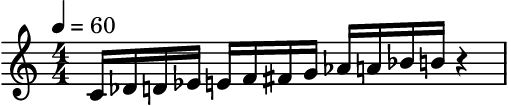

OfflineRenderer(sr=44100)
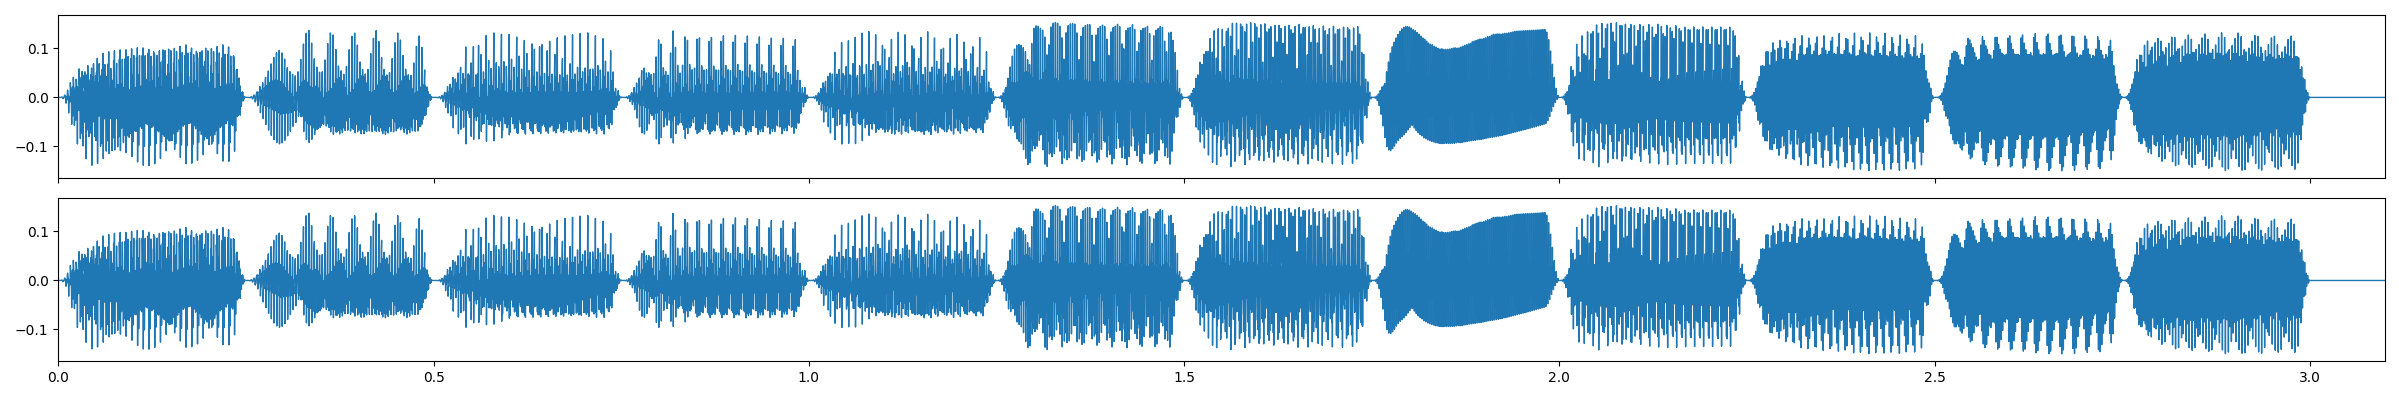

In [11]:
scale = Chain([Note(m, dur=0.25) for m in range(60, 72)])
scale.show()
scale.rec(extratime=0.1)

OfflineRenderer(sr=48000)
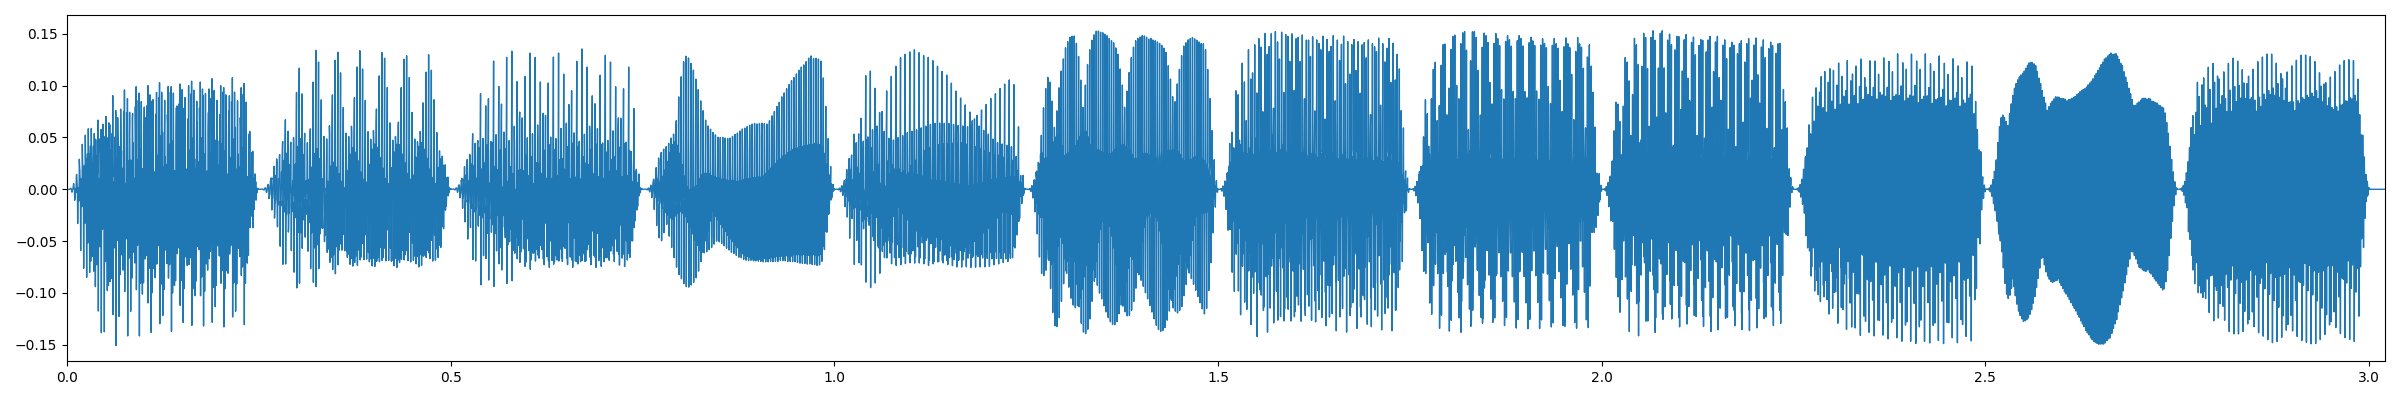

In [12]:
conf['rec.sr'] = 48000     # set default recording samplerate
scale.rec(nchnls=1)

----------------



## The active Workspace

At any moment there is one (and only one) active workspace. Whenever a config is made active, it is assigned to the active Workspace

A workspace contains the following attributes:

* `.config` (`CoreConfig`): a config 
* `.scorestruct` (`ScoreStruct`): a score structure 
* `.dynamicCurve`: a dynamics curve, mapping dynamics to amplitudes
* internal attributes which determine the current state

In [2]:
w = getWorkspace()
w

Workspace(scorestruct=ScoreStruct(4/4, tempo=60), config={'play.instr': '.piano'}, dynamicCurve=DynamicCurve(shape=expon(0.3), mindb=-60.0, maxdb=0.0))

In [3]:
if w.isActive():
    print("This is the active workspace")

if w.config is getConfig():
    print("Its config is active")
    

This is the active workspace
Its config is active


## Ad-hoc config

It is possible to create a config to perform only one specific set of actions. This is accomplished by using a `CoreConfig` as **context manager**

OfflineRenderer(sr=44100)
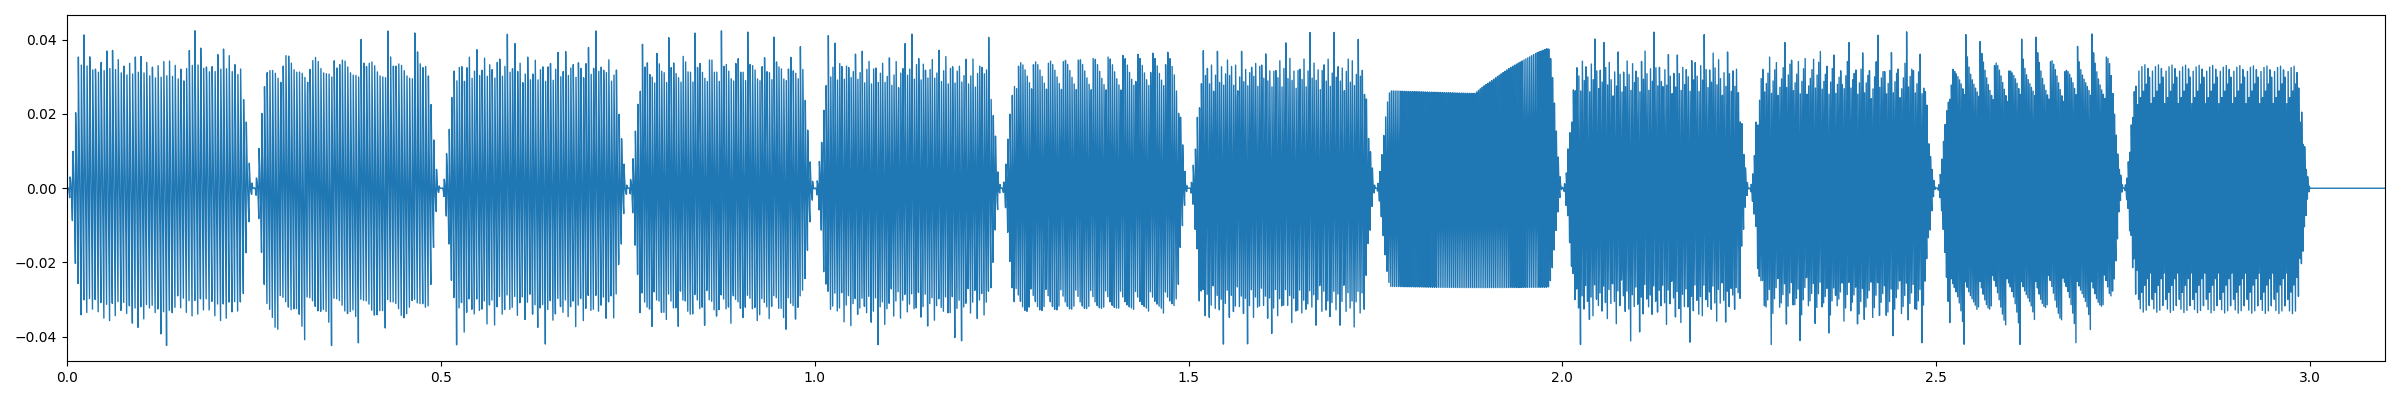

OfflineRenderer(sr=44100)
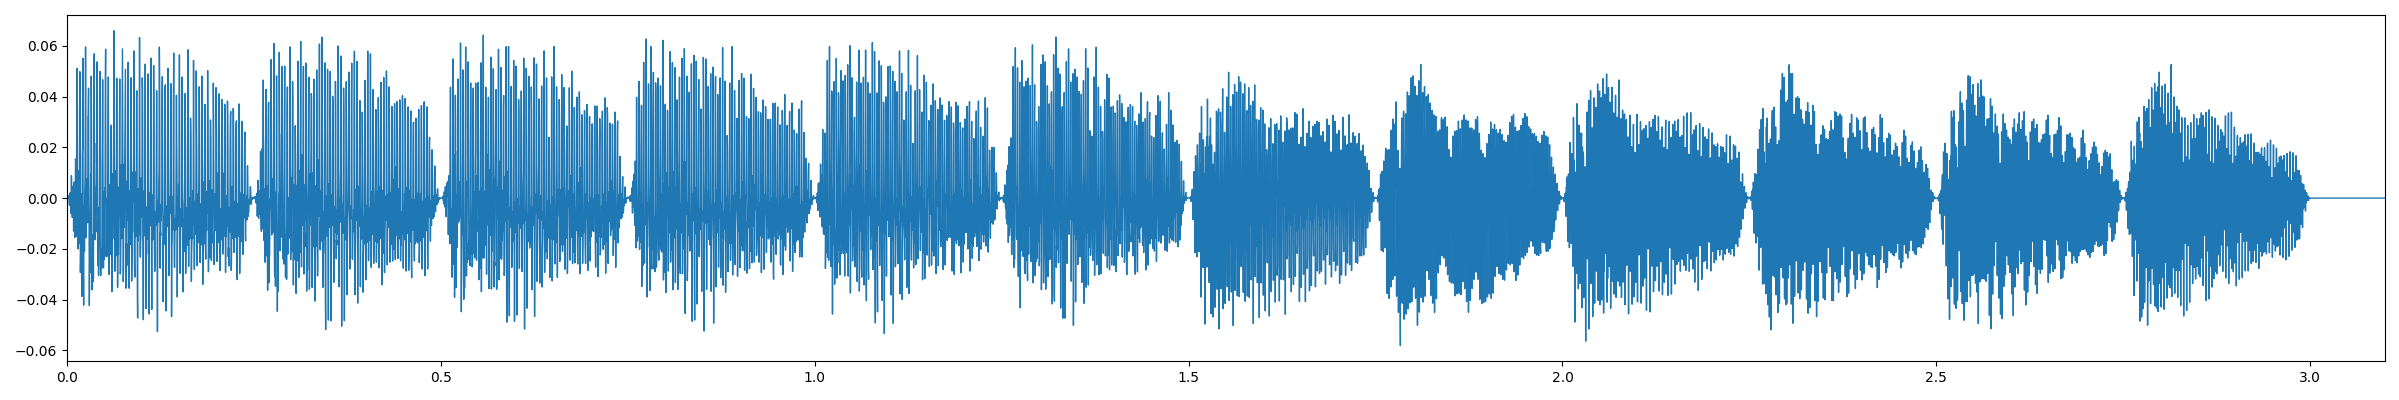

In [4]:
scale = Chain([Note(m, dur=0.25) for m in range(60, 72)])

with CoreConfig({'play.instr': 'saw'}):
    scale.rec(gain=0.1, nchnls=1, extratime=0.1).show()

# Outside the context the instr uses the previous default
scale.rec(nchnls=1, extratime=0.1)